# Predictive Modeling for Insurance Claims

This notebook is created as part of the **coding challenge for the Insurance Company (HUK_Coburg)**. The task is to build a predictive model to estimate the **expected claim amount per policyholder per year**. This value is critical for determining fair insurance premiums.

---

## Problem Statement

The dataset consists of two files:
1. **`freMTPL2freq.arff`**: Contains policy-level risk features such as vehicle type, driver age, and region.
2. **`freMTPL2sev.arff`**: Contains claim severity data, i.e., the claim amounts for each policy.

The goal is to:
- Predict the **expected claim amount per year** for individual policyholders based on the risk features.
- Use this prediction to assist in calculating fair insurance premiums.

## Approach

The notebook follows the following steps:
1. **Data Loading and Preparation**:
   - Load the datasets from ARFF format.
   - Perform any necessary preprocessing for analysis.

2. **Exploratory Data Analysis (EDA)**:
   - Understand the distribution of key features.
   - Identify potential problems such as missing values or outliers.

3. **Feature Engineering**:
   - Prepare the features for modeling (e.g., encoding categorical variables, scaling).

4. **Model Selection and Training**:
   - Train and validate multiple models to identify the best-performing approach.
   - Fine-tune the selected model using grid search.

5. **Evaluation and Interpretation**:
   - Evaluate the model using metrics such as RMSE, MAE, and R².
   - Analyze feature importance to understand the key drivers of claims.

---



## Data Loading and Initial Exploration

In this step:
- Load the datasets (`freMTPL2freq` and `freMTPL2sev`) using the `arff` library.
- Convert the data into Pandas DataFrames for further analysis.
- Perform quick checks for:
  - Dataset structure and sample rows.
  - Missing values and duplicates.
  - Descriptive statistics to understand data distributions.

> **Note**: Update the file paths in the code to match the location of the datasets on your system.


In [47]:
import pandas as pd
import arff

#load the data
data_freq = arff.load('/path/to/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
"VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
#quick check of the data 

print(df_freq.info())
print(df_freq.head())
print("Missing values in the dataset:", df_freq.isnull().sum())
print("Duplicate", df_freq.duplicated(subset='IDpol').sum())
print(df_freq.describe())

#load the second dataset
data_sev = arff.load('/path/to/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])
print(df_sev.info())
print(df_sev.head())
print("Missing values in the dataset:", df_sev.isnull().sum())
print("Duplicate", df_sev.duplicated(subset='IDpol').sum())
print(df_sev.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB
None
   IDpol  ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0    1.0      1.0      0.10  'D'       5.0     0.0     55.0        50.0   
1    3.0      1.0      0.77  'D'       5.0     0.0     55.0        50.0   
2    5.0      1.0 

In [50]:
#EDA for raw data (briefly)
# Unique values for categorical variables
for col in ['Area', 'VehBrand', 'VehGas', 'Region']:
    print(f"Unique values in {col}:")
    print(df_freq[col].value_counts())
    print()

# Fill NaN ClaimAmount with 0 for policies with no claims
df_sev['ClaimAmount'] = df_sev['ClaimAmount'].fillna(0)
print(df_sev)

Unique values in Area:
Area
'C'    191880
'D'    151596
'E'    137167
'A'    103957
'B'     75459
'F'     17954
Name: count, dtype: int64

Unique values in VehBrand:
VehBrand
'B12'    166024
'B1'     162736
'B2'     159861
'B3'      53395
'B5'      34753
'B6'      28548
'B4'      25179
'B10'     17707
'B11'     13585
'B13'     12178
'B14'      4047
Name: count, dtype: int64

Unique values in VehGas:
VehGas
Regular    345877
Diesel     332136
Name: count, dtype: int64

Unique values in Region:
Region
'R24'    160601
'R82'     84752
'R93'     79315
'R11'     69791
'R53'     42122
'R52'     38751
'R91'     35805
'R72'     31329
'R31'     27285
'R54'     19046
'R73'     17141
'R41'     12990
'R25'     10893
'R26'     10492
'R23'      8784
'R22'      7994
'R83'      5287
'R74'      4567
'R94'      4516
'R21'      3026
'R42'      2200
'R43'      1326
Name: count, dtype: int64



## Data Merging and Feature Exploration

In this step:
1. **Sum Duplicate Entries**: Aggregate `ClaimAmount` in the severity dataset (`df_sev`) for each `IDpol` (policy ID).
2. **Merge Datasets**: Combine the frequency dataset (`df_freq`) and severity dataset (`df_sev`) on `IDpol` using an outer join to ensure no data is lost.
3. **Handle Missing Values**:
   - Fill missing `ClaimAmount` values with 0 for policies with no claims.
   - Drop rows with any remaining missing values to ensure data integrity.
4. **Feature Engineering**:
   - Drop the `IDpol` column as it is no longer required.
   - Define a new target variable `ExpectedClaim`, calculated as the ratio of `ClaimAmount` to `Exposure`.

visualize:
- The distributions of numerical features (e.g., `ClaimAmount`, `Exposure`, `ExpectedClaim`) using histograms.
- The distributions of categorical variables (`Area`, `VehBrand`, `VehGas`, `Region`) using bar plots.



   ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
0      1.0      0.10  'D'       5.0     0.0     55.0        50.0    'B12'   
1      1.0      0.77  'D'       5.0     0.0     55.0        50.0    'B12'   
2      1.0      0.75  'B'       6.0     2.0     52.0        50.0    'B12'   
3      1.0      0.09  'B'       7.0     0.0     46.0        50.0    'B12'   
4      1.0      0.84  'B'       7.0     0.0     46.0        50.0    'B12'   

    VehGas  Density Region  ClaimAmount  ExpectedClaim  
0  Regular   1217.0  'R82'          0.0            0.0  
1  Regular   1217.0  'R82'          0.0            0.0  
2   Diesel     54.0  'R22'          0.0            0.0  
3   Diesel     76.0  'R72'          0.0            0.0  
4   Diesel     76.0  'R72'          0.0            0.0  


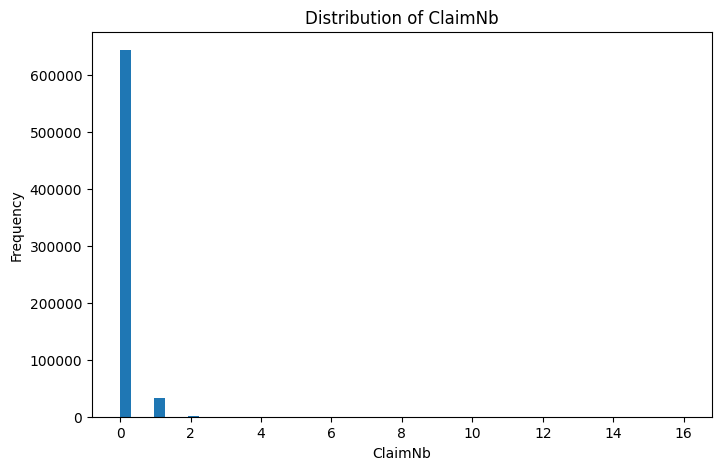

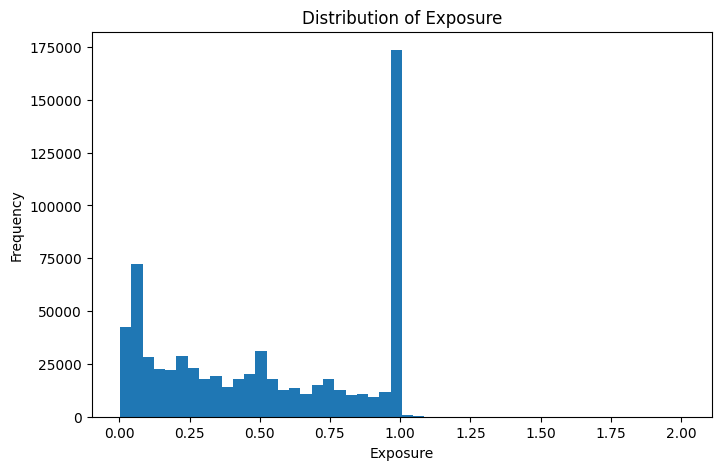

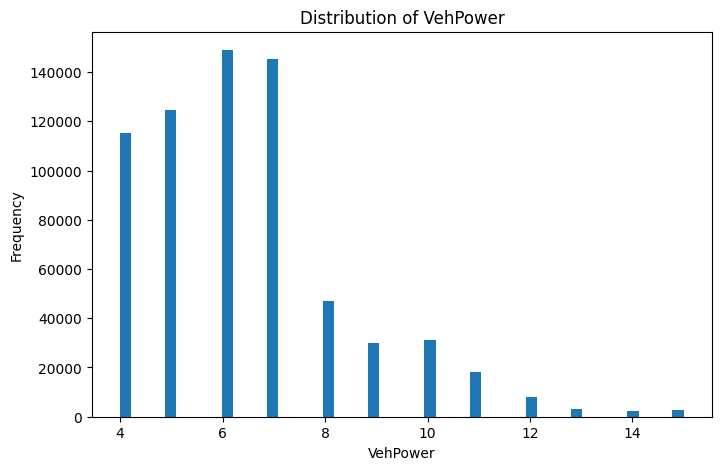

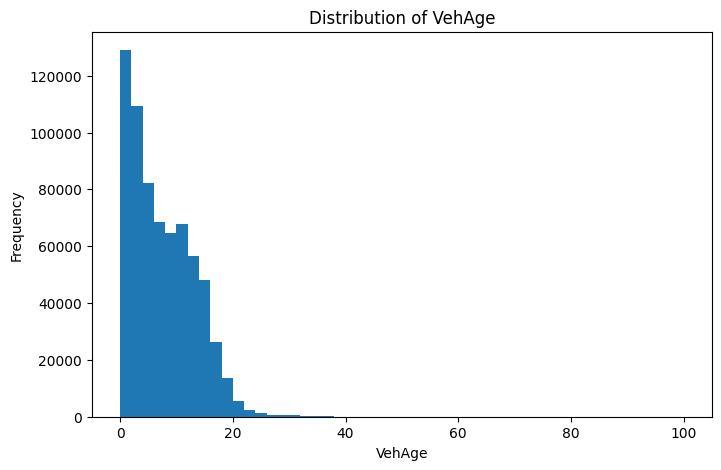

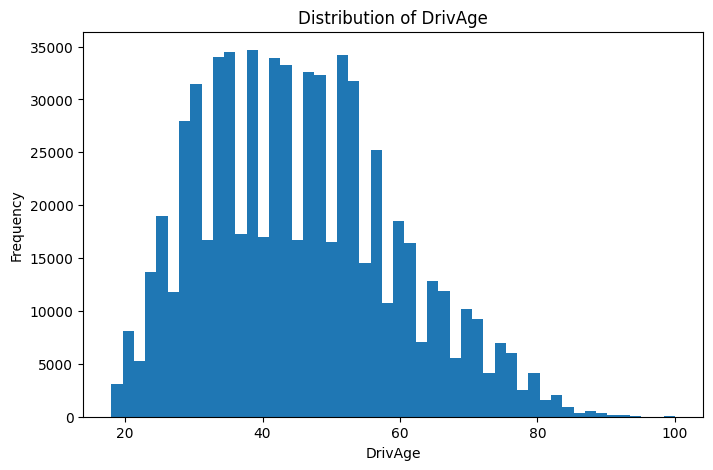

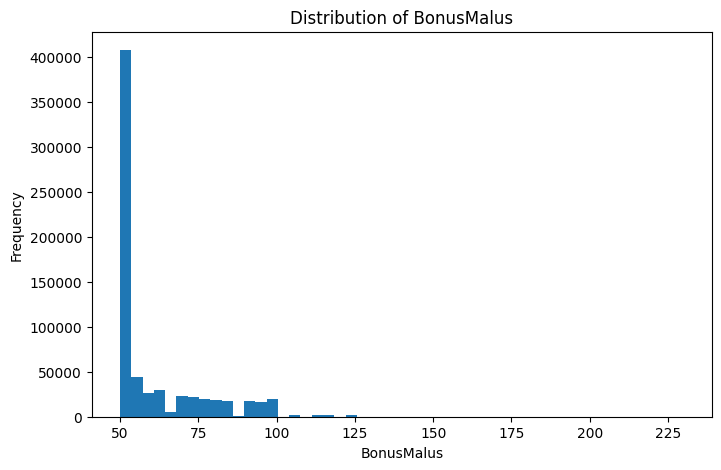

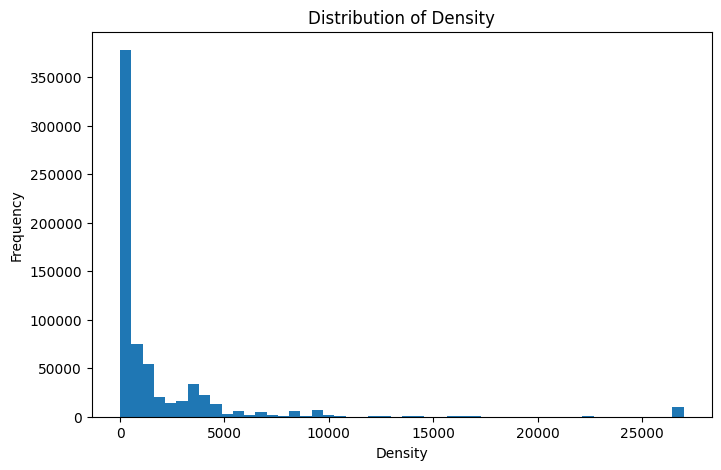

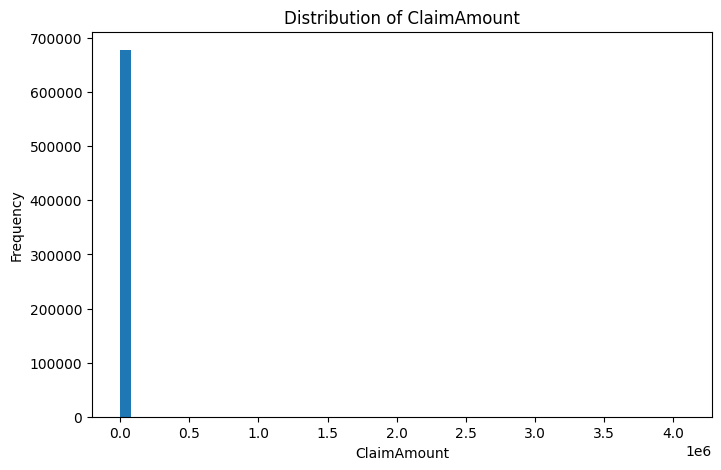

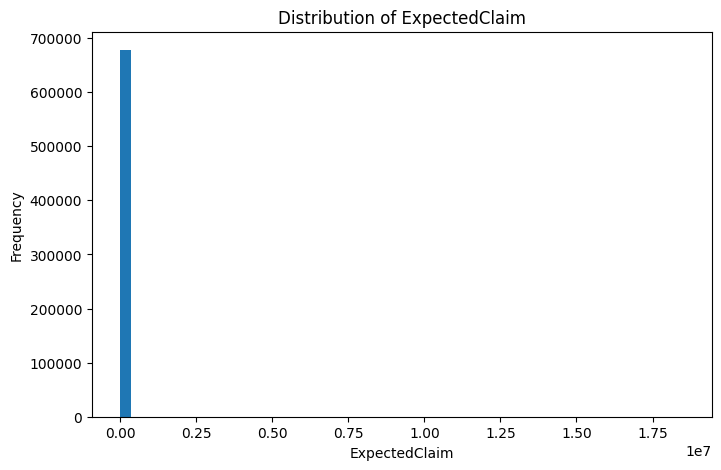

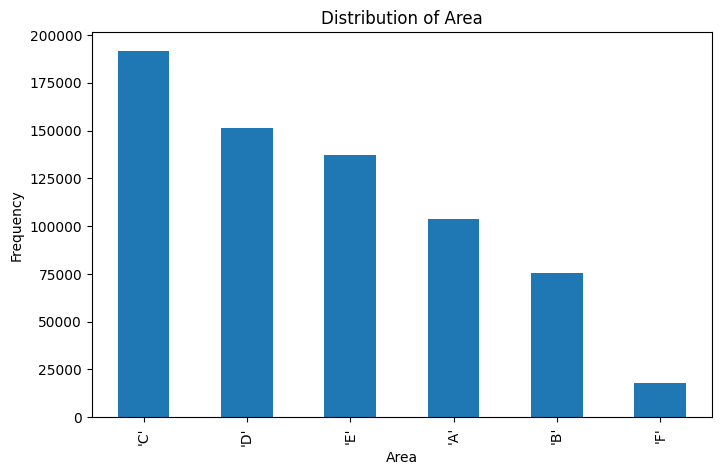

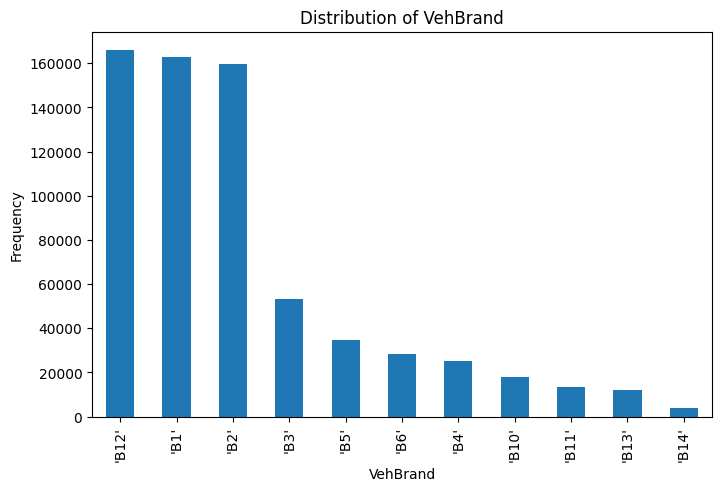

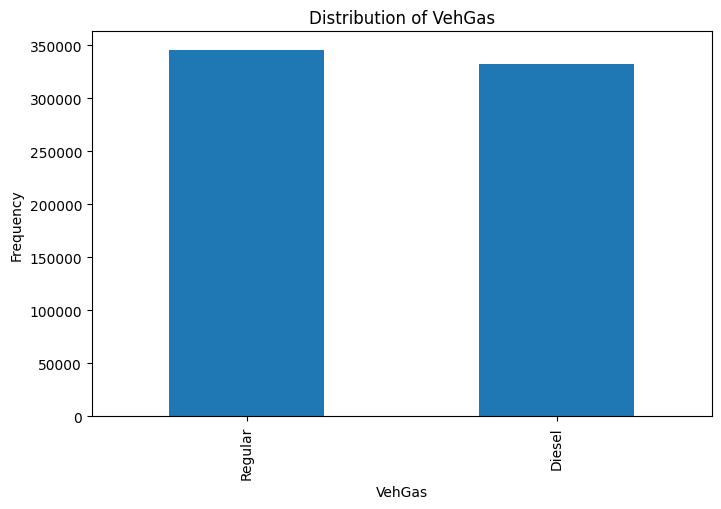

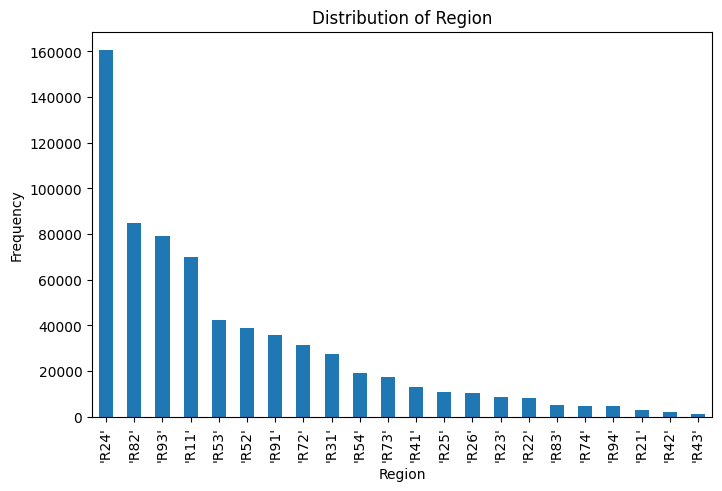

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ExpectedClaim
0,1.0,0.10000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
1,1.0,0.77000,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82',0.0,0.0
2,1.0,0.75000,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22',0.0,0.0
3,1.0,0.09000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
4,1.0,0.84000,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72',0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
678014,0.0,0.00274,'E',4.0,0.0,54.0,50.0,'B12',Regular,3317.0,'R93',0.0,0.0
678015,0.0,0.00274,'E',4.0,0.0,41.0,95.0,'B12',Regular,9850.0,'R11',0.0,0.0
678016,0.0,0.00274,'D',6.0,2.0,45.0,50.0,'B12',Diesel,1323.0,'R82',0.0,0.0
678017,0.0,0.00274,'B',4.0,0.0,60.0,50.0,'B12',Regular,95.0,'R26',0.0,0.0


In [52]:
#Sum multiple entries in df_sev by IDpol
df_sev = df_sev.groupby("IDpol", as_index=False).agg({'ClaimAmount': 'sum'})

# Merge df_freq and df_sev on IDpol
merged_df = pd.merge(df_freq, df_sev, on="IDpol", how="outer")

#Handle missing values
merged_df["ClaimAmount"] = merged_df["ClaimAmount"].fillna(0)  # Fill missing ClaimAmount with 0
merged_df = merged_df.dropna(how="any")  # Drop rows with remaining NaN values

# Drop the IDpol column
merged_df = merged_df.drop(['IDpol'], axis=1)

# Define the regression target
merged_df["ExpectedClaim"] = merged_df["ClaimAmount"] / merged_df["Exposure"]
print(merged_df.head())
# Visualizing distributions of input and output features
import matplotlib.pyplot as plt

for column in merged_df.columns:
    if merged_df[column].dtype in ['float64', 'int64']:
        plt.figure(figsize=(8, 5))
        merged_df[column].hist(bins=50)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.grid(False)
        plt.show()


# List of categorical columns
categorical_columns = ['Area', 'VehBrand', 'VehGas', 'Region']

# Plot the distributions of categorical variables using bar plots
for column in categorical_columns:
    plt.figure(figsize=(8, 5))
    merged_df[column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(False)
    plt.show()





from IPython.display import display
display(merged_df)



## Handling Skewness and Outliers in `ExpectedClaim`

The `ExpectedClaim` distribution is highly skewed, with:
- A small average value due to the majority of claims being zero.
- A high standard deviation caused by extreme outliers (top 1% of values).

### Steps Taken:
1. **Investigate Outliers**:
   - Examine the top 1% of `ExpectedClaim` values for their potential impact on the model.

2. **Address Outliers**:
   - **Option 1**: Exclude the top 1% of `ExpectedClaim` values to reduce the effect of extreme values.
   - **Option 2**: Cap the values at the 99th percentile using the `clip()` function for a more robust dataset.

3. **Log Transformation**:
   - Apply a log transformation to the `ExpectedClaim` values to address skewness and make the distribution more normal-like.
   - Visualize the log-transformed distribution

### Observations:
- Outlier handling (capping or filtering) reduces noise and stabilizes the target variable for modeling.
- Log transformation significantly improves the symmetry of the distribution

In [53]:
print(merged_df["ExpectedClaim"].describe())
# Investigate top 1% of ExpectedClaim values
high_claims = merged_df[merged_df["ExpectedClaim"] > merged_df["ExpectedClaim"].quantile(0.99)]
print(high_claims)
# Exclude top 1% of values
filtered_df = merged_df[merged_df["ExpectedClaim"] < merged_df["ExpectedClaim"].quantile(0.99)]

# Alternatively, cap values at the 99th percentile
cap_threshold = merged_df["ExpectedClaim"].quantile(0.99)
merged_df["ExpectedClaim"] = merged_df["ExpectedClaim"].clip(upper=cap_threshold)
print(merged_df.head())

count    6.780130e+05
mean     3.832608e+02
std      3.682070e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.852455e+07
Name: ExpectedClaim, dtype: float64
        ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
93          1.0      0.14  'B'      12.0     5.0     50.0        60.0   
199         1.0      0.14  'E'       4.0     0.0     36.0        85.0   
205         2.0      0.62  'F'      10.0     0.0     51.0       100.0   
223         1.0      0.31  'A'       5.0     0.0     45.0        50.0   
587         1.0      0.79  'B'       7.0     7.0     28.0        80.0   
...         ...       ...  ...       ...     ...      ...         ...   
677209      1.0      0.18  'C'       4.0     1.0     26.0        60.0   
677481      1.0      0.14  'C'       7.0     2.0     51.0        50.0   
677505      1.0      0.17  'D'       4.0     0.0     35.0        51.0   
677522      2.0      0.17  'C'      15.0     3.0     36.0 

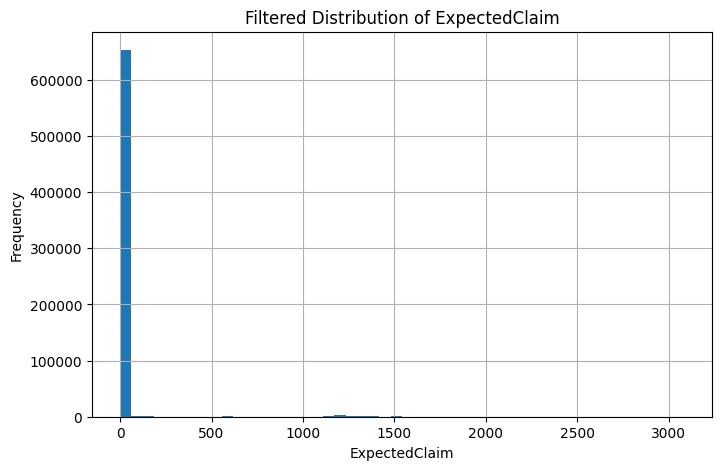

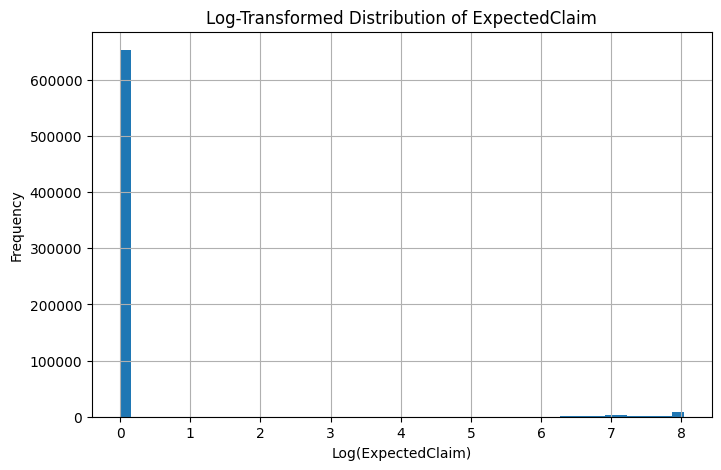

In [54]:
# Plot the filtered distribution
filtered_df["ExpectedClaim"].hist(bins=50, figsize=(8, 5))
plt.title("Filtered Distribution of ExpectedClaim")
plt.xlabel("ExpectedClaim")
plt.ylabel("Frequency")
plt.show()
import numpy as np

# Apply log transformation
merged_df["LogExpectedClaim"] = np.log1p(merged_df["ExpectedClaim"])  # Handles zeros safely

# Plot the log-transformed distribution
merged_df["LogExpectedClaim"].hist(bins=50, figsize=(8, 5))
plt.title("Log-Transformed Distribution of ExpectedClaim")
plt.xlabel("Log(ExpectedClaim)")
plt.ylabel("Frequency")
plt.show()


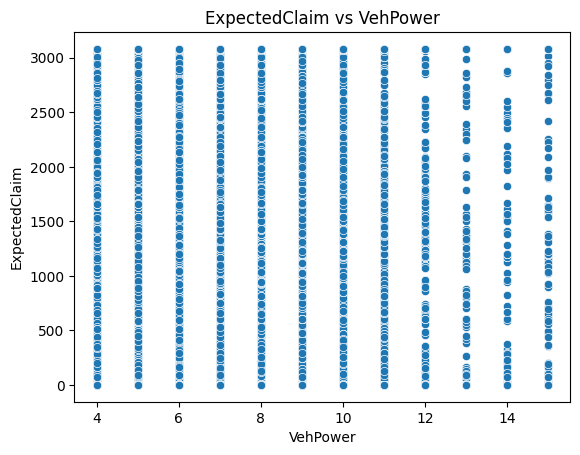

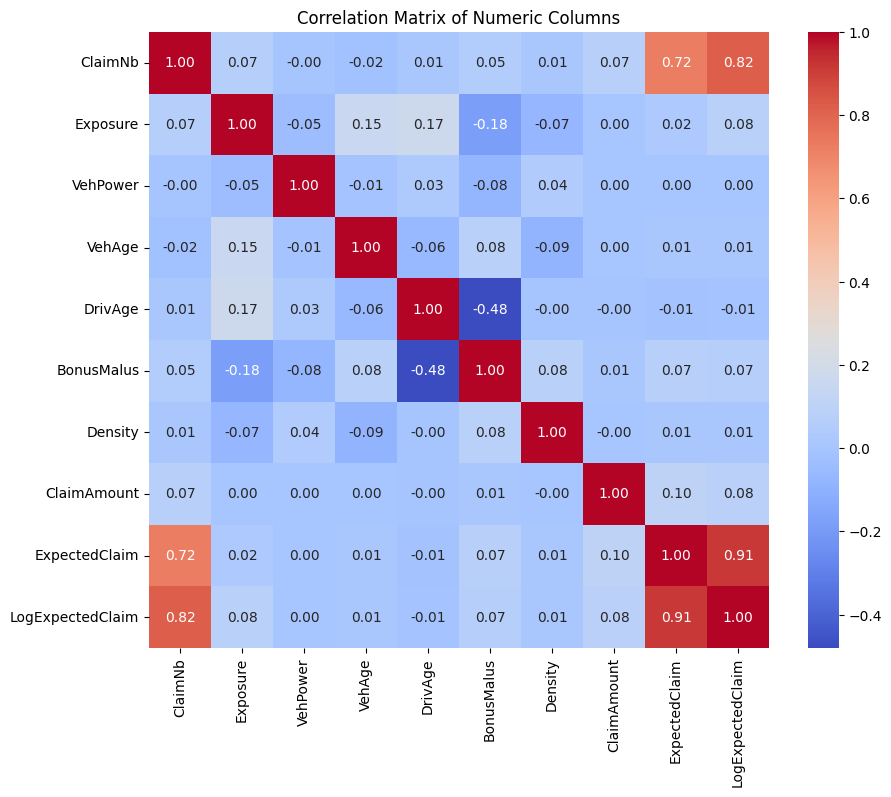

In [55]:
import seaborn as sns

# Scatter plot for ExpectedClaim vs VehPower
sns.scatterplot(data=merged_df, x="VehPower", y="ExpectedClaim")
plt.title("ExpectedClaim vs VehPower")
plt.xlabel("VehPower")
plt.ylabel("ExpectedClaim")
plt.show()

# Select only numeric columns
numeric_cols = merged_df.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Columns")
plt.show()



## Data Preparation and Model Selection

This step involves preparing the data for regression modeling, as the goal is to predict the continuous target variable, `ExpectedClaim`, based on the input features.

### Steps:
1. **Feature Encoding**:
   - Categorical variables (`Area`, `VehBrand`, `VehGas`, `Region`) are one-hot encoded to make them suitable for regression models.
   
2. **Data Splitting**:
   - The dataset is split into training (80%) and test (20%) sets for model training and evaluation.

3. **Feature Scaling**:
   - StandardScaler is used to standardize numerical features, ensuring that models are not affected by feature scaling differences.

4. **Model Selection**:
   - Several regression models are trained and evaluated. Based on performance metrics, **LightGBM** is selected as the best-performing model and further optimized.



In [58]:
from sklearn.preprocessing import StandardScaler
print("Columns in merged_df:", merged_df.columns)
print(merged_df.head)
# Encoding categorical variables
merged_df = pd.get_dummies(merged_df, columns=['Area', 'VehBrand', 'VehGas', 'Region'], drop_first=True)
print('after cat',merged_df.head())
# Splitting the data into features and target
X = merged_df.drop(columns=["ExpectedClaim"])  # Features
print('X',X.head())
y = merged_df["ExpectedClaim"]                # Target variable
print('y',y.head())
# Splitting into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.head())
print("Training features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Columns in merged_df: Index(['ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimAmount',
       'ExpectedClaim', 'LogExpectedClaim'],
      dtype='object')
<bound method NDFrame.head of         ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus  \
0           1.0   0.10000  'D'       5.0     0.0     55.0        50.0   
1           1.0   0.77000  'D'       5.0     0.0     55.0        50.0   
2           1.0   0.75000  'B'       6.0     2.0     52.0        50.0   
3           1.0   0.09000  'B'       7.0     0.0     46.0        50.0   
4           1.0   0.84000  'B'       7.0     0.0     46.0        50.0   
...         ...       ...  ...       ...     ...      ...         ...   
678014      0.0   0.00274  'E'       4.0     0.0     54.0        50.0   
678015      0.0   0.00274  'E'       4.0     0.0     41.0        95.0   
678016      0.0   0.00274  'D'       6.0     2.0     45.0        50.0   
6

In [ ]:
#linear regression model as a baseline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train the model
baseline_model = LinearRegression()
baseline_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test_scaled)

# Evaluate the model
print("Baseline Model Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_baseline))
print("RMSE:", mean_squared_error(y_test, y_pred_baseline))
print("R²:", r2_score(y_test, y_pred_baseline))


Baseline Model Metrics:
MAE: 44.44277087211534
RMSE: 24818.120598712903
R²: 0.8386487830674987


In [26]:
#RandomForest model
from sklearn.ensemble import RandomForestRegressor

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", mean_squared_error(y_test, y_pred_rf))
print("R²:", r2_score(y_test, y_pred_rf))

Random Forest Metrics:
MAE: 0.0038084367773057737
RMSE: 0.002287500988610966
R²: 0.999999985128162


In [27]:
from sklearn.linear_model import TweedieRegressor

# Train the model
tweedie_model = TweedieRegressor(power=1.5, alpha=0.5)
tweedie_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_tweedie = tweedie_model.predict(X_test_scaled)

# Evaluate the model
print("Tweedie Regression Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_tweedie))
print("RMSE:", mean_squared_error(y_test, y_pred_tweedie))
print("R²:", r2_score(y_test, y_pred_tweedie))


Tweedie Regression Metrics:
MAE: 12.921815816974695
RMSE: 20335.037075909364
R²: 0.867794865226996


In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize LightGBM Regressor
lgb_model = lgb.LGBMRegressor(
    n_estimators=100,      # Number of boosting iterations (trees)
    learning_rate=0.1,     # Step size shrinkage
    max_depth=6,           # Maximum depth of trees
    random_state=42        # Random seed for reproducibility
)

# Train the model
lgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Evaluate the model
print("LightGBM Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_lgb))
print("RMSE:", mean_squared_error(y_test, y_pred_lgb))
print("R²:", r2_score(y_test, y_pred_lgb))


/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1268
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 46
[LightGBM] [Info] Start training from score 64.355059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Metrics:
MAE: 0.06441661999036481
RMSE: 0.33036910617533405
R²: 0.9999978521557623


In [ ]:
from xgboost import XGBRegressor

# Train the model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model
print("XGBoost Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", mean_squared_error(y_test, y_pred_xgb))
print("R²:", r2_score(y_test, y_pred_xgb))


XGBoost Metrics:
MAE: 0.07905826718960071
RMSE: 0.5109964246570279
R²: 0.9999966778348651


In [ ]:
#try NN for the task of regression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),  # Dropout for regularization
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
# Train the model
history = nn_model.fit(X_train_scaled, y_train, 
                       validation_data=(X_test_scaled, y_test),
                       epochs=50, batch_size=32, verbose=1)

# Evaluate the model on test data
loss, mae = nn_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predict on test data
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred_nn)
rmse = mean_squared_error(y_test, y_pred_nn)
r2 = r2_score(y_test, y_pred_nn)

print("Neural Network Metrics:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


Model Comparison:
                Model      MAE        RMSE        R²
0   Linear Regression  44.4400  24818.1000  0.838600
1       Random Forest   0.0038      0.0023  1.000000
2  Tweedie Regression  12.9200  20335.0000  0.867800
3            LightGBM   0.0644      0.3304  0.999998
4             XGBoost   0.0791      0.5110  0.999997
5                  NN   8.3100   2008.5400  0.987000


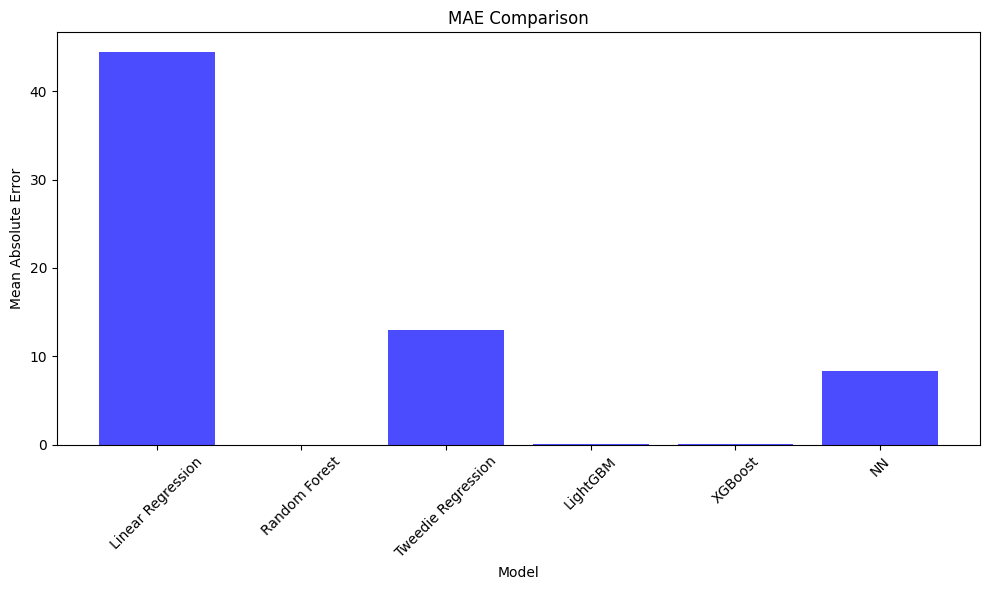

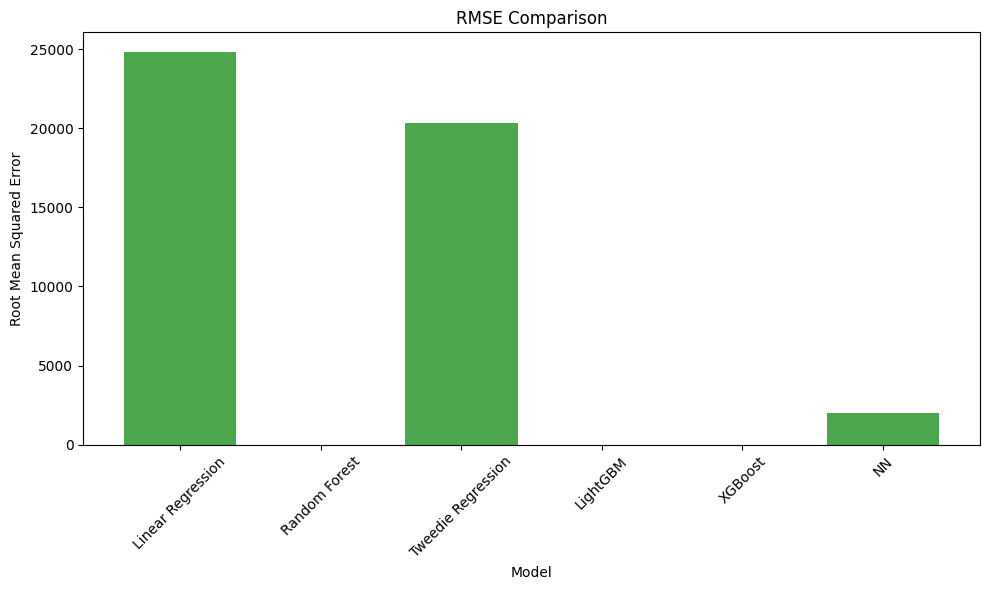

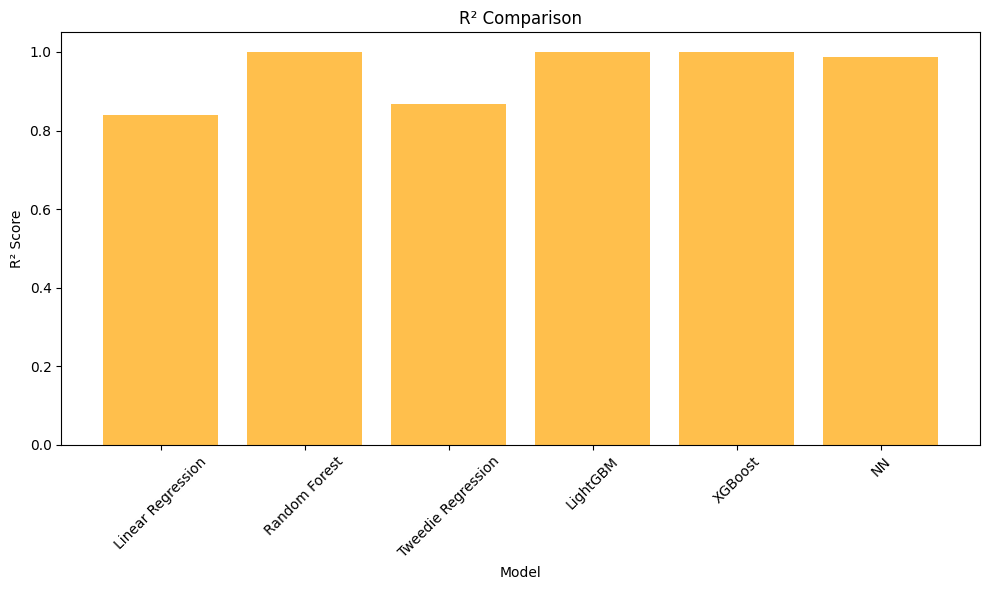

In [ ]:
# Results based on the provided metrics
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "Tweedie Regression", "LightGBM", "XGBoost", "NN"],
    "MAE": [44.44, 0.0038, 12.92, 0.0644, 0.0791, 8.31],
    "RMSE": [24818.1, 0.0023, 20335.0, 0.3304, 0.5110, 2008.54],
    "R²": [0.8386, 0.99999999, 0.8678, 0.9999979, 0.9999967,0.987]
})

# Display the comparison table
print("Model Comparison:")
print(results)

# Plot MAE Comparison
plt.figure(figsize=(10, 6))
plt.bar(results["Model"], results["MAE"], color='blue', alpha=0.7)
plt.title("MAE Comparison")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot RMSE Comparison
plt.figure(figsize=(10, 6))
plt.bar(results["Model"], results["RMSE"], color='green', alpha=0.7)
plt.title("RMSE Comparison")
plt.ylabel("Root Mean Squared Error")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot R² Comparison
plt.figure(figsize=(10, 6))
plt.bar(results["Model"], results["R²"], color='orange', alpha=0.7)
plt.title("R² Comparison")
plt.ylabel("R² Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 ## Model Selection: Why LightGBM?

Based on initial results, **LightGBM** stands out as the best-performing model for this task:

### Performance Metrics:
- **MAE (0.064)**: The second lowest error, indicating a very small average prediction error.
- **RMSE (0.330)**: The lowest among all models, showing LightGBM handles large deviations better than others.
- **R²**: Nearly 1, meaning the model explains almost all the variance in the target variable.

### Why Choose LightGBM?
- **Efficiency**: LightGBM trains significantly faster compared to Random Forest or Neural Networks.
- **Interpretability**: Using tools like SHAP (SHapley Additive exPlanations), the decisions made by boosted trees are more interpretable, providing insights into feature importance and predictions.
(However I didnt use SHAP here its possible to do it!)

### Next Steps:
- Optimize the LightGBM model for even better performance.

In [ ]:
#Hyperparameter tuning for LGBM 
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'num_leaves': [15, 31, 63],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

In [15]:
# Best parameters and performance
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", (-grid_search.best_score_) ** 0.5)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.8}
Best RMSE: 7.314661706554738


In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

best_lgb_model = grid_search.best_estimator_

# Cross-validation
cv_scores = cross_val_score(
    best_lgb_model,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

# Compute RMSE from cross-validation scores
cv_rmse = np.sqrt(-cv_scores.mean())
print("Cross-Validated RMSE:", cv_rmse)


/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1013
[LightGBM] [Info] Number of data points in the train set: 542410, number of used features: 45
[LightGBM] [Info] Start training from score 64.355059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Metrics:
MAE: 0.5995084851399595
RMSE: 40.61328662661005
R²: 0.9997359589258675


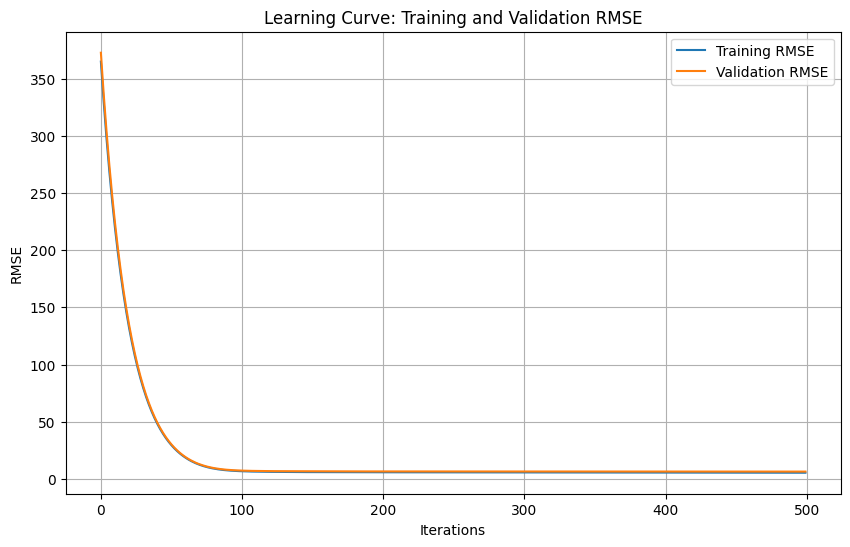

In [ ]:
#this is to compare the fine tuned lgb model with the baseline model

from lightgbm import log_evaluation

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=1.0
    )
#best Parameters from gridsearch: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 7, 
# 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.8}Best RMSE: 7.314661706554738
# Train the model with evaluation metrics
lgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_metric='rmse',
    #verbose=10  # Enables metric logging every 10 iterations
)

# Extract learning curve data
evals_result = lgb_model.evals_result_

y_pred_lgb = lgb_model.predict(X_test_scaled)
print("LightGBM Metrics:")
print("MAE:", mean_absolute_error(y_test, y_pred_lgb))
print("RMSE:", mean_squared_error(y_test, y_pred_lgb))
print("R²:", r2_score(y_test, y_pred_lgb))



# Plot training and validation RMSE
plt.figure(figsize=(10, 6))
plt.plot(evals_result['training']['rmse'], label='Training RMSE')
plt.plot(evals_result['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Learning Curve: Training and Validation RMSE')
plt.legend()
plt.grid()
plt.show()

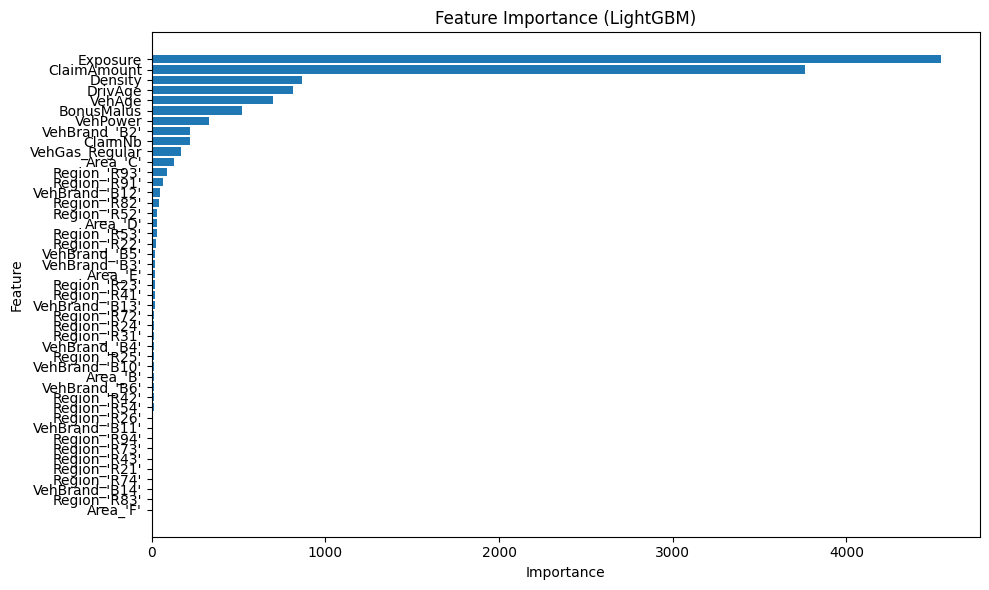

In [17]:
import matplotlib.pyplot as plt

# Feature importance
importances = best_lgb_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({"Feature": features, "Importance": importances}).sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (LightGBM)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
#groupby the one-hot-encoded features for better visualization
#additionally one can do the SHAP analysis to fruther study the features

In [ ]:
# Predict on test data
y_pred = best_lgb_model.predict(X_test_scaled)

# Evaluate the final model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
final_mae = mean_absolute_error(y_test, y_pred)
final_rmse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print("Final LightGBM Metrics:")
print(f"MAE: {final_mae}")
print(f"RMSE: {final_rmse}")
print(f"R²: {final_r2}")


/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Final LightGBM Metrics:
MAE: 0.5995084851399595
RMSE: 40.61328662661005
R²: 0.9997359589258675


In [ ]:
# Evaluate on training set
y_train_pred = best_lgb_model.predict(X_train_scaled)
train_rmse = mean_squared_error(y_train, y_train_pred)

# Evaluate on validation/test set
y_test_pred = best_lgb_model.predict(X_test_scaled)
test_rmse = mean_squared_error(y_test, y_test_pred)

print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Training RMSE: 28.934550477208973
Test RMSE: 40.61328662661005


/opt/miniconda3/envs/test_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


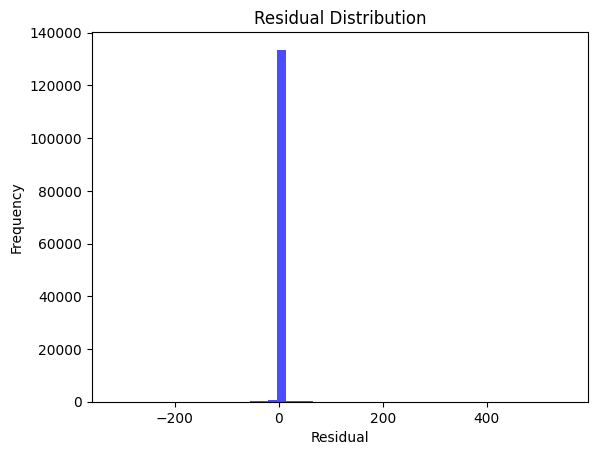

In [33]:
residuals = y_test - best_lgb_model.predict(X_test_scaled)
plt.hist(residuals, bins=50, color='blue', alpha=0.7)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

## Conclusion

The LightGBM model demonstrated strong performance in predicting `ExpectedClaim`:

### Key Findings:
1. **Residual Distribution**:
   - Residuals are concentrated around zero, indicating that the model predictions are unbiased.
   - Minimal large residuals suggest effective handling of both small and large claims.

2. **Training and Validation Learning Curve**:
   - The training and validation RMSE converge smoothly, indicating no overfitting or underfitting.
   - The final RMSE stabilizes after ~200 iterations, showing effective optimization.

3. **Evaluation Metrics**:
   - **Training RMSE**: 28.93
   - **Test RMSE**: 40.61
   - The relatively small difference between training and test RMSE indicates good generalization.

### Final Remarks:
The LightGBM model is a robust choice for this regression problem due to its ability to handle outliers, efficiency in training, and excellent generalization. Future work could focus on refining hyperparameters further, exploring additional features, or implementing advanced interpretability techniques like SHAP.
